### Urban form and its impacts on air pollution and access to green space

Compare urban form metrics and examine their correlations with each other across geographic regions and socioeconomic characteristics such as income. 

Using the K-Means clustering algorithm, develop a typology of urban forms worldwide. 

Furthermore, assesse the associations between urban form metrics and two important environmental outcomes: green space access and air pollution.

In [1]:
# Import the packages required to run the code
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid", color_codes=True)
sns.set(font_scale=1.35, style="ticks") #set styling preferences
import statsmodels.api as sm
from scipy import stats
import math
from math import pi
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2,vq, whiten

In [2]:
# Read the data
raw_dat = pd.read_csv('/home/nazanin/SprawlMeasures/Data/urban_centers_withroadtypes.csv')
GHSL = pd.read_csv('/home/nazanin/SprawlMeasures/Data/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.csv')

In [3]:
# Show all columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None

#### Data Processing

In [4]:
# Subset of dataframes - choose the columns we are going to use
uc_data = raw_dat[["id_hdc_g0", "ghs_pop", "ghs_density", "ghs_wt_density", "length_km_motorway", "n_edges_motorway", "pca1_stock", "length_km_major","n_edges_major", "compactness", "density_gradient_slope", "density_gradient_intercept", "polyc_index"]]
ghsl_stat = GHSL[["ID_HDC_G0", "AREA", "CTR_MN_NM", "CTR_MN_ISO", "GRGN_L1", "GRGN_L2", "UC_NM_MN","E_GR_AT14", "E_EPM2_R15", "UC_NM_LST", "SDG_OS15MX", "SDG_A2G14","SDG_LUE9015","E_CPM2_T14","E_EPM2_A15","E_EPM2_T15","E_EPM2_E15","E_EC2O_A15","E_EC2O_T15","E_EC2O_R15","E_EC2O_E15","E_EC2E_A15","DEV_CMI", "INCM_CMI","GDP15_SM","BUCAP15","P15","B15"]]

In [5]:
# Sort values and reset index
uc_data = uc_data.sort_values('id_hdc_g0').reset_index(drop=True)

In [6]:
# Convert key column to numeric
ghsl_stat = ghsl_stat.copy()
ghsl_stat['ID_HDC_G0'] = pd.to_numeric(ghsl_stat['ID_HDC_G0'])  

In [7]:
# Set index
uc_data_ind = uc_data.set_index('id_hdc_g0', drop=True, append=False, inplace=False)
ghsl_stat_ind = ghsl_stat.set_index('ID_HDC_G0', drop=True, append=False, inplace=False)

In [8]:
# Merge dataframes
GHSLjoined = pd.merge(uc_data_ind, ghsl_stat_ind, left_index=True, right_index=True, how='outer')

In [9]:
# Convert column type to object
GHSLjoined.CTR_MN_ISO = GHSLjoined.CTR_MN_ISO.astype('object')

In [10]:
# Calculate the outcome variables
GHSLjoined['greenPerCap'] = GHSLjoined.E_GR_AT14/GHSLjoined.P15
GHSLjoined['emissionsPerCap'] = GHSLjoined.E_EPM2_T15/GHSLjoined.P15 

In [11]:
# Caluclate the log of variables
GHSLjoined['logpop15'] = GHSLjoined.loc[:,'P15'].apply(np.log)
GHSLjoined['logpm25T15'] = GHSLjoined.loc[:,'E_EPM2_T15'].apply(np.log)
GHSLjoined['log_emissionsPerCap'] = GHSLjoined.loc[:,'emissionsPerCap'].apply(np.log)
GHSLjoined['logpm25R15'] = GHSLjoined.loc[:,'E_EPM2_R15'].apply(np.log)
GHSLjoined['log_wt_density'] = GHSLjoined.ghs_wt_density.apply(np.log)

In [12]:
# Choose cities above 10 km^2
GHSLjoined = GHSLjoined[GHSLjoined['AREA'] > 10]
GHSLjoined = GHSLjoined[GHSLjoined["P15"] > 100000]
GHSLjoined = GHSLjoined.sort_values(by=['id_hdc_g0'])

In [13]:
# Choose cities above 1 million population
above_1mil_15 = GHSLjoined[GHSLjoined["P15"] > 1000000]

In [14]:
# Purpose: Sort the value of the legend of pairplots 
above_1mil_15 = above_1mil_15.sort_values("id_hdc_g0")

In [15]:
# Drop the outliers
above_1mil_15 = above_1mil_15.drop(labels=[4099, 5169,7665,8078,8183], axis=0)

In [16]:
# Negate SNDi values
above_1mil_15['Street_Connectivity'] = -above_1mil_15.loc[:,'pca1_stock']
above_1mil_15.drop('pca1_stock', axis = 1, inplace = True)

#### Pairplot Income

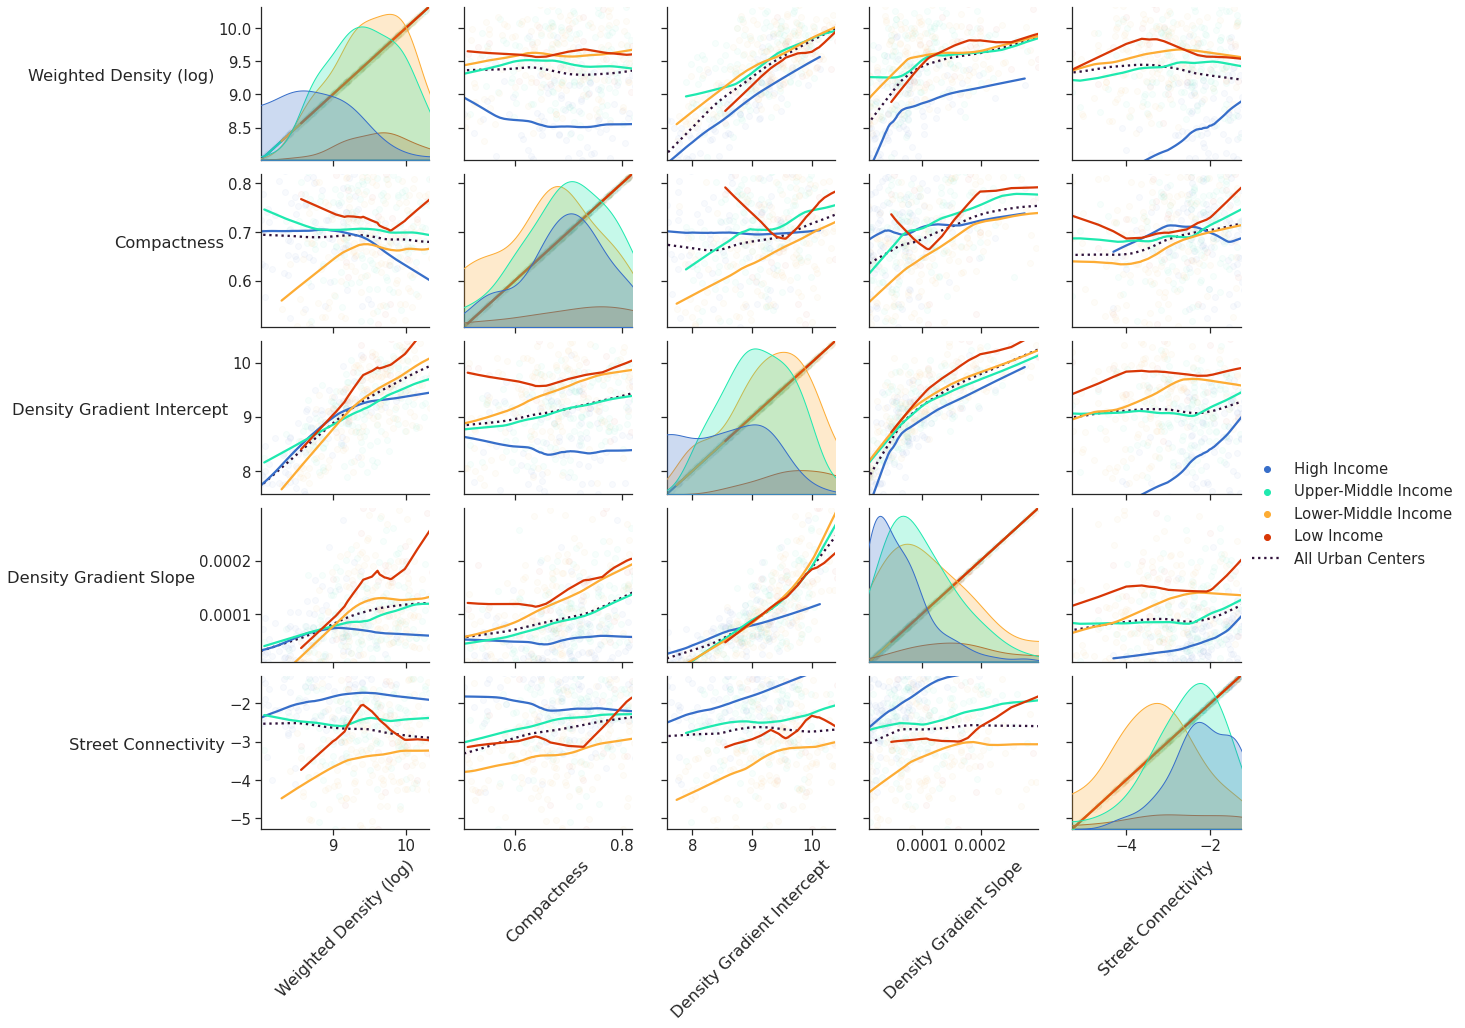

In [17]:
# Create an array with the colors you want to use
#colors = ['#33BBEE', '#0077BB', '#EE7733', '#CC3311'] vibrant
colors = ["#376ec9", "#1FE9AF", "#FDAC34", "#D83706"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
GHSLjoined.sort_values('compactness', inplace=True)
plotDf_In1 = above_1mil_15.reset_index()[['log_wt_density','compactness','density_gradient_intercept', 'density_gradient_slope','Street_Connectivity','INCM_CMI']]#'log_urban_extent_density', 'log_builtup_area_density','frag_saturation'
replacements = {'Street_Connectivity': 'Street Connectivity', 'compactness': 'Compactness',
                'polyc_index': 'Polycentricity', 'density_gradient_intercept': 'Density Gradient Intercept', 
                'density_gradient_slope': 'Density Gradient Slope', 'SDG_OS15MX': 'Open Space Percent 2015', 
                'log_wt_density': 'Weighted Density (log)','ghs_density':'Density','logpop15': 'Pop 2015', 'SDG_A2G14': 'Access to Green Space',
                'SDG_LUE9015':'LU Efficiency 1990-2015', 'logpm25R15':'PM.25 Res 2015', 'logpm25T15':'PM2.5 Tran 2015',
                'E_GR_AT14':'Total Area Green 2014', 'log_builtup_area_density':'Built-Up Area Density', 'log_urban_extent_density':'Urban Extent Density','frag_saturation':'Fragmentation: Saturation'}
ren = plotDf_In1.rename(columns=replacements)   
dict1 = {'HIC': 'High Income', 'UMIC': 'Upper-Middle Income', 'LMIC': 'Lower-Middle Income', 'LIC': 'Low Income'}
ren['Income_Class'] = ren.INCM_CMI.map(dict1)

def plot_extra(x, y, **kwargs):
     if kwargs['label'] == first_label:
            sns.regplot(data=kwargs['data'], x=x.name, y=y.name, lowess=True, scatter=False, color=kwargs['color'], line_kws={"lw":2.3, 'linestyle':'dotted'})

first_label = ren['Income_Class'][0]
pg = sns.pairplot(ren, hue='Income_Class', plot_kws={'alpha':0.0015})
pg.map_offdiag(plot_extra, color='#30123B', data=ren)
a = pg.map(sns.regplot, lowess=True, scatter_kws={'alpha':0.03})

     
for ii, col in enumerate(pg.axes):
    for jj, ax in enumerate(col):
        ax.set_ylim(ren[pg.y_vars[ii]].quantile(0.05), ren[pg.y_vars[ii]].quantile(0.95))
        ax.set_xlim(ren[pg.x_vars[jj]].quantile(0.05), ren[pg.x_vars[jj]].quantile(0.95))
        
for ax in a.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 45)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')      

legend_dict = {h.get_label(): h for h in pg.legend.legendHandles}  # the existing legend items
legend_dict['All Urban Centers'] = pg.axes[0, 1].lines[0]  # add the first line object of a non-diagonal ax to the legend

pg.legend.remove()  # remove existing legend
pg.add_legend(legend_dict, label_order=legend_dict.keys(), title='')  # create the new legend    
    
pg.savefig('Fig2.tif', dpi=300)

#### Pairplot Green Space

<Figure size 1800x1200 with 0 Axes>

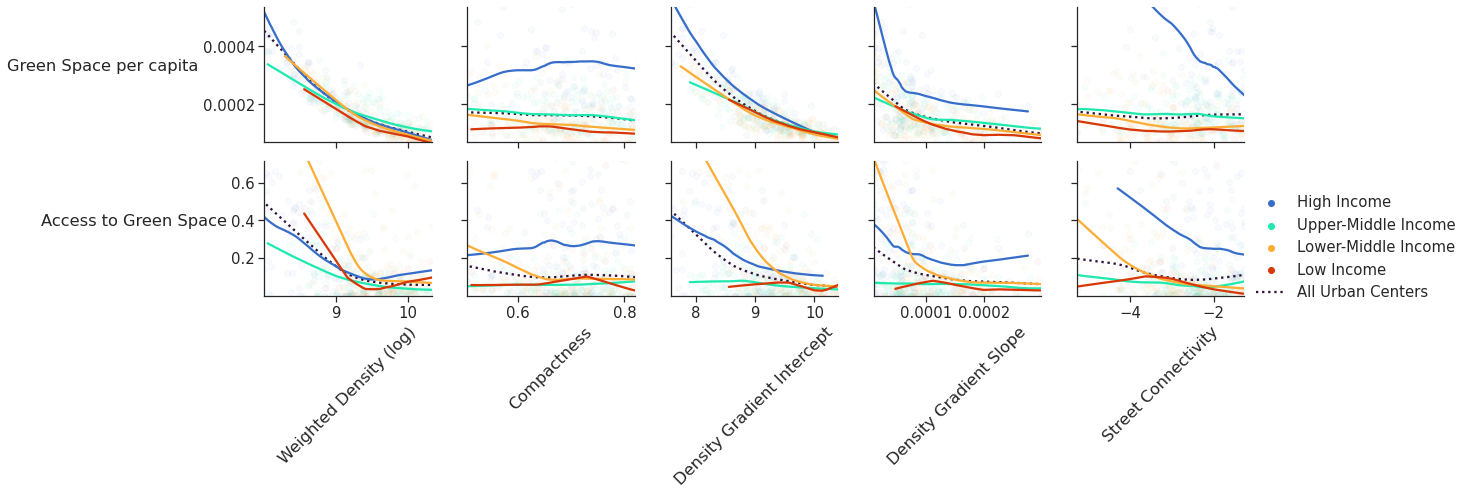

In [18]:
# Create an array with the colors you want to use
colors = ["#376ec9", "#1FE9AF", "#FDAC34", "#D83706"] 
# Set your custom color palette
plt.figure(dpi=300)
sns.set_palette(sns.color_palette(colors))
GHSLjoined.sort_values('compactness', inplace=True)
plotDf_In1 = above_1mil_15.reset_index()[['log_wt_density','compactness','density_gradient_intercept', 
                                          'density_gradient_slope','Street_Connectivity','INCM_CMI', 
                                          'greenPerCap','SDG_A2G14']]#'log_urban_extent_density', 'log_builtup_area_density','frag_saturation'
replacements = {'Street_Connectivity': 'Street Connectivity', 'compactness': 'Compactness',
                'density_gradient_intercept': 'Density Gradient Intercept', 
                'density_gradient_slope': 'Density Gradient Slope', 'log_wt_density': 'Weighted Density (log)',
                'greenPerCap': 'Green Space per capita', 'SDG_A2G14':'Access to Green Space'}
ren = plotDf_In1.rename(columns=replacements)   
dict1 = {'HIC': 'High Income', 'UMIC': 'Upper-Middle Income', 'LMIC': 'Lower-Middle Income', 'LIC': 'Low Income'}
ren['Income_Class'] = ren.INCM_CMI.map(dict1)

def plot_extra(x, y, **kwargs):
     if kwargs['label'] == first_label:
            sns.regplot(data=kwargs['data'], x=x.name, y=y.name, lowess=True, scatter=False, color=kwargs['color'], line_kws={"lw":2.3, 'linestyle':'dotted'})

first_label = ren['Income_Class'][0]

pg = sns.pairplot(ren, hue='Income_Class', plot_kws={'alpha':0.0015},
                  x_vars=['Weighted Density (log)', 'Compactness', 'Density Gradient Intercept', 'Density Gradient Slope',
                          'Street Connectivity',],
                  y_vars=['Green Space per capita','Access to Green Space'])
pg.map_offdiag(plot_extra, color='#30123B', data=ren)
a = pg.map(sns.regplot, lowess=True, scatter_kws={'alpha':0.03})

legend_dict = {h.get_label(): h for h in pg.legend.legendHandles}  # the existing legend items
legend_dict['All Urban Centers'] = pg.axes[0, 1].lines[0]  # add the first line object of a non-diagonal ax to the legend

pg.legend.remove()  # remove existing legend
pg.add_legend(legend_dict, label_order=legend_dict.keys(), title='')  # create the new legend 

for ii, col in enumerate(pg.axes):
    for jj, ax in enumerate(col):
        ax.set_ylim(ren[pg.y_vars[ii]].quantile(0.05), ren[pg.y_vars[ii]].quantile(0.95))
        ax.set_xlim(ren[pg.x_vars[jj]].quantile(0.05), ren[pg.x_vars[jj]].quantile(0.95))
        
for ax in a.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 45)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')
    
pg.savefig('Fig6.tif', dpi=300)

#### Pairplot Emissions

<Figure size 1800x1200 with 0 Axes>

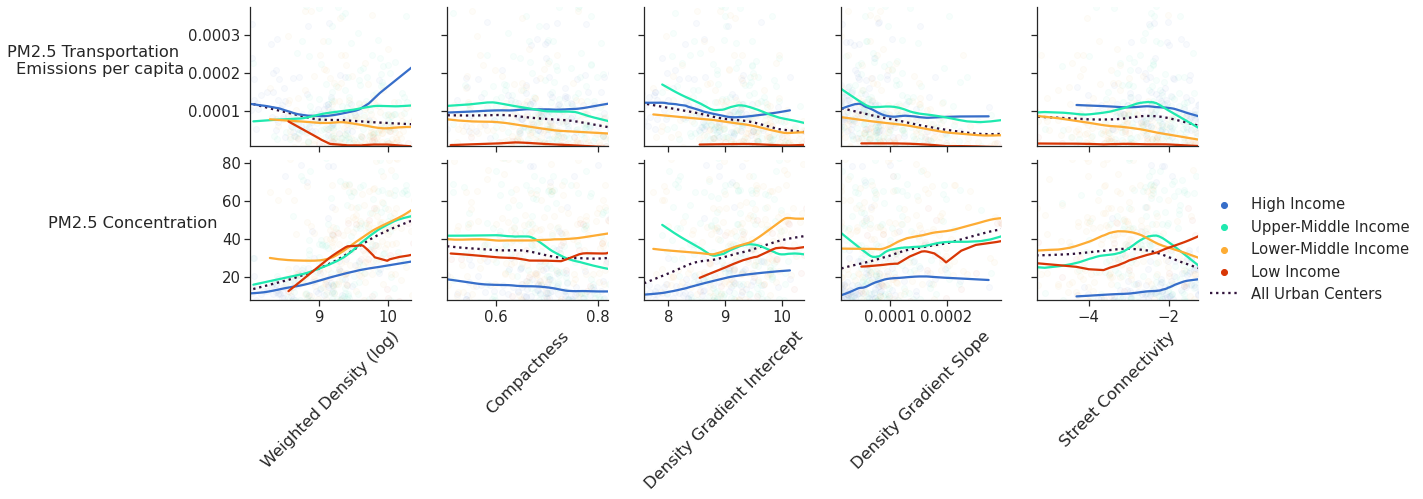

In [19]:
# Create an array with the colors you want to use
colors = ['#376ec9', "#1FE9AF", "#FDAC34", "#D83706"]
# Set your custom color palette
plt.figure(dpi=300)
sns.set_palette(sns.color_palette(colors))
GHSLjoined.sort_values('compactness', inplace=True)
plotDf_In1 = above_1mil_15.reset_index()[['log_wt_density','compactness','density_gradient_intercept', 
                                          'density_gradient_slope','Street_Connectivity','INCM_CMI', 
                                          'emissionsPerCap','E_CPM2_T14']]#'log_urban_extent_density', 'log_builtup_area_density','frag_saturation'
replacements = {'Street_Connectivity': 'Street Connectivity', 'compactness': 'Compactness',
                'density_gradient_intercept': 'Density Gradient Intercept', 
                'density_gradient_slope': 'Density Gradient Slope', 'log_wt_density': 'Weighted Density (log)',
                'emissionsPerCap':'PM2.5 Transportation \nEmissions per capita',
                'E_CPM2_T14': 'PM2.5 Concentration'}
ren = plotDf_In1.rename(columns=replacements)   
dict1 = {'HIC': 'High Income', 'UMIC': 'Upper-Middle Income', 'LMIC': 'Lower-Middle Income', 'LIC': 'Low Income'}
ren['Income_Class'] = ren.INCM_CMI.map(dict1)

def plot_extra(x, y, **kwargs):
     if kwargs['label'] == first_label:
            sns.regplot(data=kwargs['data'], x=x.name, y=y.name, lowess=True, scatter=False, color=kwargs['color'], line_kws={"lw":2.3, 'linestyle':'dotted'})

first_label = ren['Income_Class'][0]

pg = sns.pairplot(ren, hue='Income_Class', plot_kws={'alpha':0.0015},
                  x_vars=['Weighted Density (log)', 'Compactness', 'Density Gradient Intercept', 'Density Gradient Slope',
                          'Street Connectivity'],
                  y_vars=['PM2.5 Transportation \nEmissions per capita','PM2.5 Concentration'])
pg.map_offdiag(plot_extra, color='#30123B', data=ren)
a = pg.map(sns.regplot, lowess=True, scatter_kws={'alpha':0.03})

legend_dict = {h.get_label(): h for h in pg.legend.legendHandles}  # the existing legend items
legend_dict['All Urban Centers'] = pg.axes[0, 1].lines[0]  # add the first line object of a non-diagonal ax to the legend

pg.legend.remove()  # remove existing legend
pg.add_legend(legend_dict, label_order=legend_dict.keys(), title='')  # create the new legend 

for ii, col in enumerate(pg.axes):
    for jj, ax in enumerate(col):
        ax.set_ylim(ren[pg.y_vars[ii]].quantile(0.05), ren[pg.y_vars[ii]].quantile(0.95))
        ax.set_xlim(ren[pg.x_vars[jj]].quantile(0.05), ren[pg.x_vars[jj]].quantile(0.95))
        
for ax in a.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 45)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')
    
pg.savefig('Fig9.tif', dpi=300)

### KMeans in scikit-learn

In [23]:
# see https://scikit-learn.org/stable/modules/preprocessing.html for standardization
from sklearn import preprocessing
plotDf_In = above_1mil_15.reset_index()[['log_wt_density','compactness','density_gradient_intercept', 'density_gradient_slope', 'Street_Connectivity']]
scaler = preprocessing.StandardScaler().fit(plotDf_In)

# the scaler returns a numpy array, so we cast this as a DataFrame and need to specify the column names and index
df_scaled = pd.DataFrame(scaler.transform(plotDf_In), columns=['log_wt_density','compactness','density_gradient_intercept', 'density_gradient_slope','Street_Connectivity'], index=above_1mil_15.index)

In [24]:
from sklearn.cluster import KMeans
df_scaled = df_scaled.dropna()
kmeans = KMeans(n_clusters=5, random_state = 4).fit(df_scaled)

In [25]:
#Running K-Means with a range of k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_scaled)
    distortions.append(kmeanModel.inertia_)

In [27]:
kmeans.cluster_centers_
kmeans.labels_
print(kmeans.cluster_centers_.shape)
print(len(df_scaled.columns))

(5, 5)
5


In [28]:
# The 'labels_' object assigns each row in your dataframe (i.e., each precinct), to a cluster.
print(kmeans.labels_.shape)
print(len(df_scaled))

(462,)
462


In [29]:
# We can simply add the cluster id back to our original dataframe!
df_scaled.loc[:,'cluster_id'] = kmeans.labels_
centroids = kmeans.cluster_centers_

In [30]:
# code from https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [34]:
# Set the colors
colors5 = [(0.1882,0.07058,0.2313),(0.29042,0.9137,0.6862),(0.99654,0.63193,0.18738),(0.27691,0.44145,0.91328), (0.73661,0.12477,0.00769)]  

<Figure size 1800x1200 with 0 Axes>

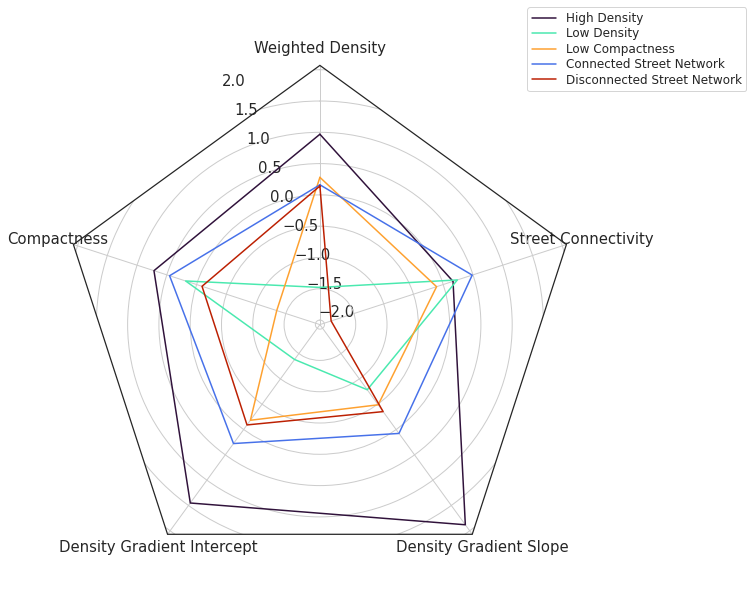

In [35]:
# radar plot 5 clusters
%matplotlib inline
plt.figure(dpi=300)

# let's put this in a function so we can call it easily again
def radar_plot(kmeans, df_scaled):
    N  = kmeans.cluster_centers_.shape[1]  # number of columns / variables
    k = kmeans.n_clusters
    theta = radar_factory(N, frame='polygon')
    data = kmeans.cluster_centers_.T
    #spoke_labels = [col for col in df_scaled.columns if col!='cluster_id']
    ######
    spoke_labels = ['Weighted Density','Compactness','Density Gradient Intercept','Density Gradient Slope','Street Connectivity']
    ######
    fig, ax = plt.subplots(figsize=(14, 9),
                                subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)


    #ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    #        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
    #                     horizontalalignment='center', verticalalignment='center')
    #        for d, color in zip(case_data, colors):
    for ii in range(k):
        ax.plot(theta, data[:,ii], color=colors5[ii])
        #ax.fill(theta,  data[:,ii], facecolor=colors5[ii], alpha=0.1)
    ax.set_varlabels(spoke_labels)
    
    # add legend relative to top-left plot
    labels = ['Cluster {}'.format(kk) for kk in range(k)]
    #######
    labels = ['High Density','Low Density','Low Compactness','Connected Street Network','Disconnected Street Network']
    #######
    ax.legend(labels, loc=(0.9, .95),
                                labelspacing=0.2, fontsize='large')
    fig.savefig('radar.tif', dpi=300)
radar_plot(kmeans, df_scaled)

#### Distance to Centroids

In [36]:
# add distances from each cluster to centroid
# cdist returns a matrix of sum of distances to each cluster centroid
nClusters = 5 
colsToUseDict = {1: ['log_wt_density','compactness','density_gradient_intercept','density_gradient_slope','Street_Connectivity'],}
columns = colsToUseDict[1]
sses = cdist(df_scaled[columns], centroids, 'sqeuclidean') 
for clustId in range(nClusters):
            mask = (df_scaled.cluster_id==clustId)
            df_scaled.loc[df_scaled.cluster_id==clustId,'dist2centroid'] = sses[mask.values, clustId]

In [37]:
# Mapping the clusters
import geopandas as gpd

gdf = gpd.read_file("/home/nazanin/SprawlMeasures/Data/UrbanCenter_shp/urbancenters.shp")  # you might need to adjust the path

# note that there is no projection file, so geopandas doesn't know the coordinate system
print(gdf.crs)

# the docs say it's in lat/lon
gdf.crs = 'EPSG:4326'

epsg:4326


In [38]:
gdf.geometry = gdf.geometry.centroid

<ipython-input-38-678d9b959363>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.geometry = gdf.geometry.centroid


In [39]:
# If we join on id_hdc_g0, it looks like we can do a 1:1 join since both columns are unique
# If we do a left join from gdf, we'll have some missing data but that's OK

# Rename the column so both are lowercase
gdf.rename(columns={'ID_HDC_G0':'id_hdc_g0'}, inplace=True)
gdf.set_index('id_hdc_g0', inplace=True)

In [40]:
# Join files
joinedGdf = gdf.join(df_scaled)

In [41]:
# Add green space per capita column
joinedGdf['greenpercap'] = joinedGdf.E_GR_AT14/joinedGdf.P15
joinedGdf['emissionsPerCap'] = joinedGdf.E_EPM2_T15/GHSLjoined.P15 

In [42]:
# log of PM2.5
joinedGdf['logpm25T15'] = joinedGdf.E_EPM2_T15.apply(np.log)
joinedGdf['log_emissionsPerCap'] = joinedGdf.loc[:,'emissionsPerCap'].apply(np.log)
joinedGdf['pm25Conc'] = joinedGdf.E_CPM2_T14.apply(np.log)
joinedGdf['log_share_green'] = joinedGdf.SDG_A2G14.apply(np.log)
joinedGdf['logpop15'] = joinedGdf.loc[:,'P15'].apply(np.log)

In [43]:
# Population above 1 million
selected_rows = joinedGdf[~joinedGdf['cluster_id'].isnull()]
joinedGdf2 = selected_rows[selected_rows["P15"] > 1000000]

In [44]:
# Subset of data
clusters5pop = joinedGdf.groupby(['id_hdc_g0', 'CTR_MN_NM', 'cluster_id', 'UC_NM_MN', 'AREA', 'P15', 'B15', 'DEV_CMI', 'INCM_CMI', 'GRGN_L1', 'log_wt_density','compactness','density_gradient_intercept', 'density_gradient_slope', 'Street_Connectivity', 'GRGN_L2', 'greenpercap', 'log_emissionsPerCap', 'pm25Conc','SDG_A2G14'])['dist2centroid'].mean()

#### Map - Geographic distribution of the clusters

<Figure size 4200x2800 with 0 Axes>

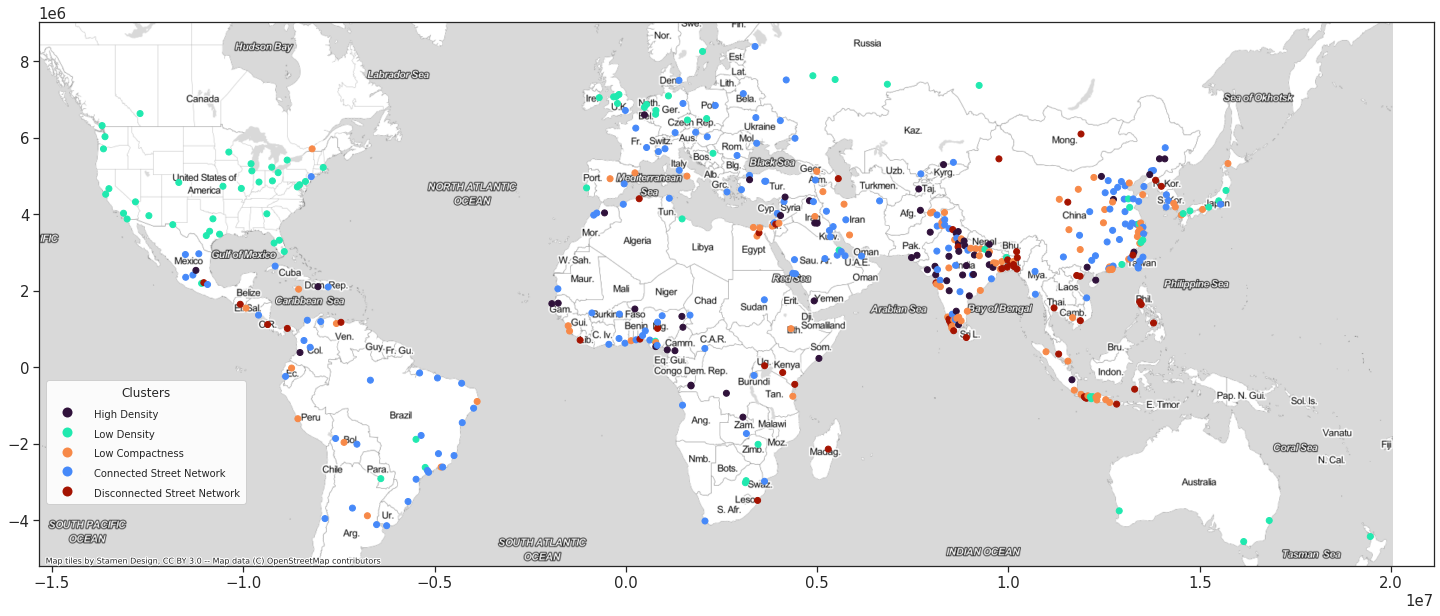

In [45]:
# now let's map. We should color code by cluster_id

import contextily as ctx
import matplotlib.pyplot as plt
# specify the colors. I find https://colorbrewer2.org the most helpful
# we should make sure cluster 5 is grey (missing data), which we represent as a string between 0 and 1
# this is 5 qualitative colors

# getting the colors into a colormap required some searching
# https://stackoverflow.com/questions/38882233/geopandas-matplotlib-plot-custom-colors
from matplotlib.colors import LinearSegmentedColormap

plt.figure(dpi=700)
cmap = LinearSegmentedColormap.from_list(
    'mycmap', [(0,'#30123B'), (0.25, '#1FE9AF'), (0.5, '#F88947'), 
               (0.75,'#458AFC'),  (1,  '#A41301')]) #, (1.0, '#fed976')

clusdict = {0.0: 'High Density', 1.0: 'Low Density', 2.0:'Low Compactness', 3.0:'Connected Street Network', 4.0:'Disconnected Street Network'}

fig, ax = plt.subplots(figsize=(25,15))
ax = plt.gca()
joinedGdf2.to_crs('EPSG:3857').plot('cluster_id', cmap=cmap, categorical=True, legend=True, ax=ax,
                                                                     legend_kwds={'loc': 'lower left'})

def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

replace_legend_items(ax.get_legend(), clusdict)
legend = ax.get_legend()
    
legend.set_title("Clusters", prop={'size':12})
legend.get_frame().set_alpha(0.9) 
legend.set_bbox_to_anchor((0., 0.1, 0.2, 0.2))
plt.setp(plt.gca().get_legend().get_texts(), fontsize='10') #legend 'list' fontsize
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
#ax.set_title('Typology of Cities based on Urban Form Metrics', fontsize=16)  
fig.savefig('map.tif', dpi=300)

#### Environmental Impacts

#### Access to Green Space

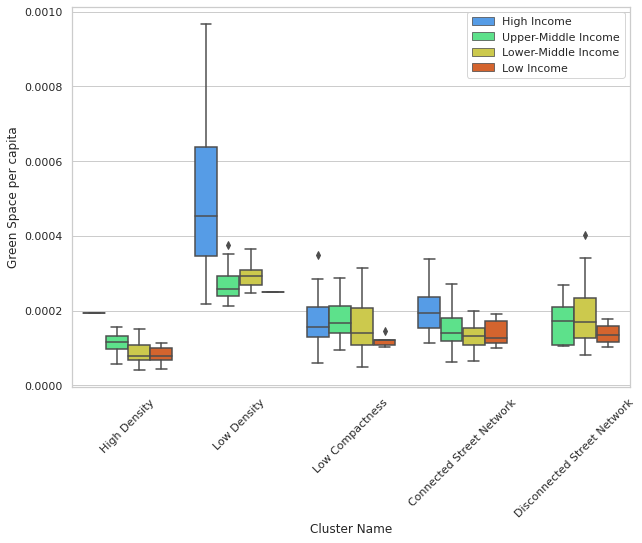

In [46]:
# Access to Green space
sns.set(rc={'figure.figsize':(10,7)})
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="cluster_id", y="greenpercap", hue="INCM_CMI",
                 data=joinedGdf2, palette="turbo")
ax.set(xlabel='Cluster Name', ylabel='Green Space per capita')
ax.set_xticklabels(['High Density','Low Density','Low Compactness','Connected Street Network','Disconnected Street Network'], rotation=45)
handles, _ = ax.get_legend_handles_labels()   # Get the artists.
ax.legend(handles, ["High Income", "Upper-Middle Income", 'Lower-Middle Income', 'Low Income'], loc="best") # Associate manually the artists to a label.
plt.savefig('Fig7.tif', bbox_extra_artists=(ax.legend(handles, ["High Income", "Upper-Middle Income", 'Lower-Middle Income', 'Low Income'], loc="best"),), bbox_inches='tight', dpi=300)

#### Share of population living in high green

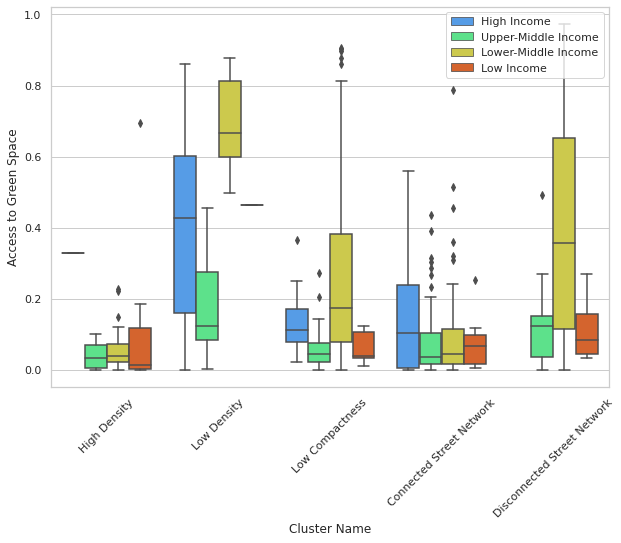

In [47]:

# Share of Population in the High Green Areas - income
sns.set(rc={'figure.figsize':(10,7)})
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="cluster_id", y="SDG_A2G14", hue="INCM_CMI",
                 data=joinedGdf2, palette="turbo")
ax.set(xlabel='Cluster Name', ylabel='Access to Green Space')
ax.set_xticklabels(['High Density','Low Density','Low Compactness','Connected Street Network','Disconnected Street Network'], rotation=45)
handles, _ = ax.get_legend_handles_labels()   # Get the artists.
ax.legend(handles, ["High Income", "Upper-Middle Income", 'Lower-Middle Income', 'Low Income'], loc="best") # Associate manually the artists to a label.
plt.savefig('Fig8.tif', bbox_extra_artists=(ax.legend(handles, ["High Income", "Upper-Middle Income", 'Lower-Middle Income', 'Low Income'], loc="best"),), bbox_inches='tight', dpi=300)

#### PM2.5 per Capita Emissions 

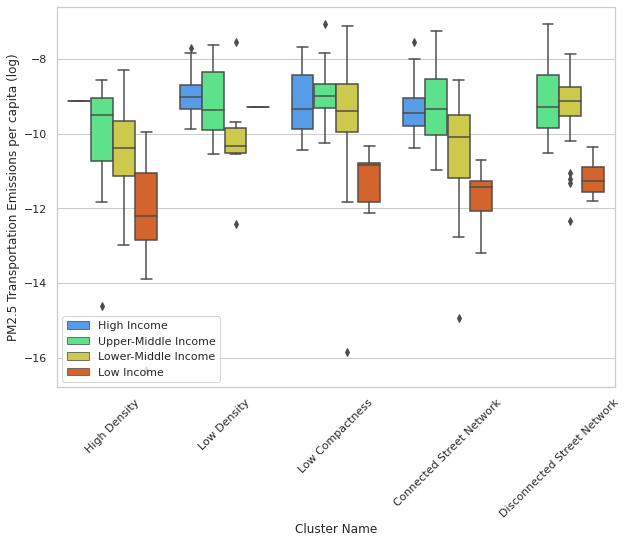

In [48]:
#log pm2.5 transportation - income
sns.set(rc={'figure.figsize':(10,7)})
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="cluster_id", y="log_emissionsPerCap", hue="INCM_CMI",
                 data=joinedGdf2, palette="turbo")
ax.set(xlabel='Cluster Name', ylabel='PM2.5 Transportation Emissions per capita (log)')
ax.set_xticklabels(['High Density','Low Density','Low Compactness','Connected Street Network','Disconnected Street Network'], rotation=45)
handles, _ = ax.get_legend_handles_labels()   # Get the artists.
ax.legend(handles, ["High Income", "Upper-Middle Income", 'Lower-Middle Income', 'Low Income'], loc="best") # Associate manually the artists to a label.
plt.savefig('Fig10.tif', bbox_extra_artists=(ax.legend(handles, ["High Income", "Upper-Middle Income", 'Lower-Middle Income', 'Low Income'], loc="best"),), bbox_inches='tight', dpi=300)

#### PM2.5 Concentration

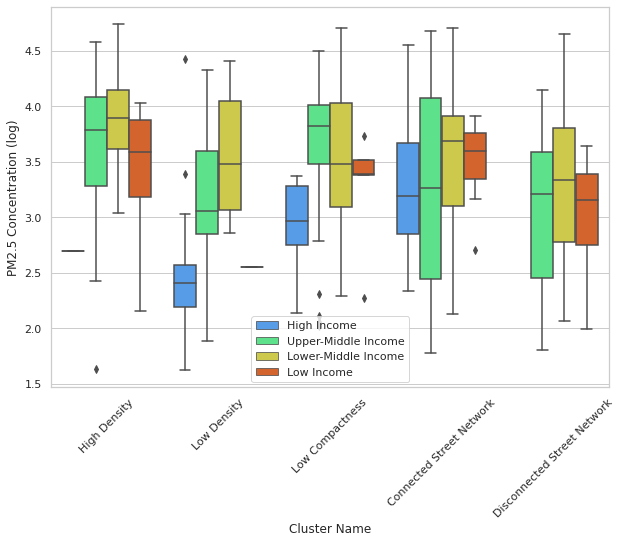

In [49]:
#log pm2.5 transportation - income
sns.set(rc={'figure.figsize':(10,7)})
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="cluster_id", y="pm25Conc", hue="INCM_CMI",
                 data=joinedGdf2, palette="turbo")
ax.set(xlabel='Cluster Name', ylabel='PM2.5 Concentration (log)')
ax.set_xticklabels(['High Density','Low Density','Low Compactness','Connected Street Network','Disconnected Street Network'], rotation=45)
handles, _ = ax.get_legend_handles_labels()   # Get the artists.
ax.legend(handles, ["High Income", "Upper-Middle Income", 'Lower-Middle Income', 'Low Income'], loc="best") # Associate manually the artists to a label.
plt.savefig('Fig11.tif', bbox_extra_artists=(ax.legend(handles, ["High Income", "Upper-Middle Income", 'Lower-Middle Income', 'Low Income'], loc="best"),), bbox_inches='tight', dpi=300)

#### Partition Pie Chart

In [57]:
df_per_region = joinedGdf2.groupby(['GRGN_L1','cluster_id']).size().reset_index(name='count_city')

In [58]:
# Change the type of the columns
df_per_region['cluster_id']= df_per_region['cluster_id'].astype(str)
df_per_region['GRGN_L1']= df_per_region['GRGN_L1'].astype(str)
df_per_region['count_city'] = pd.to_numeric(df_per_region['count_city'], errors='coerce')   

In [59]:
idlist = ['0.0', '1.0', '2.0', '3.0', '4.0']
continentlist= list(df_per_region.GRGN_L1.unique())

for continent in continentlist:
    for id in idlist:
        idexist=0
        for row in range(0,len(df_per_region.index)-1):
            if (df_per_region.iloc[row,0] == continent ) and (df_per_region.iloc[row,1] == id):
                idexist=1
            else:
                idexist=idexist
        if idexist==0:
            df_per_region.loc[len(df_per_region.index)]= [continent, id, 0.0]
            
df_per_region=df_per_region.sort_values(by=['GRGN_L1','cluster_id'])

<Figure size 3000x2100 with 0 Axes>

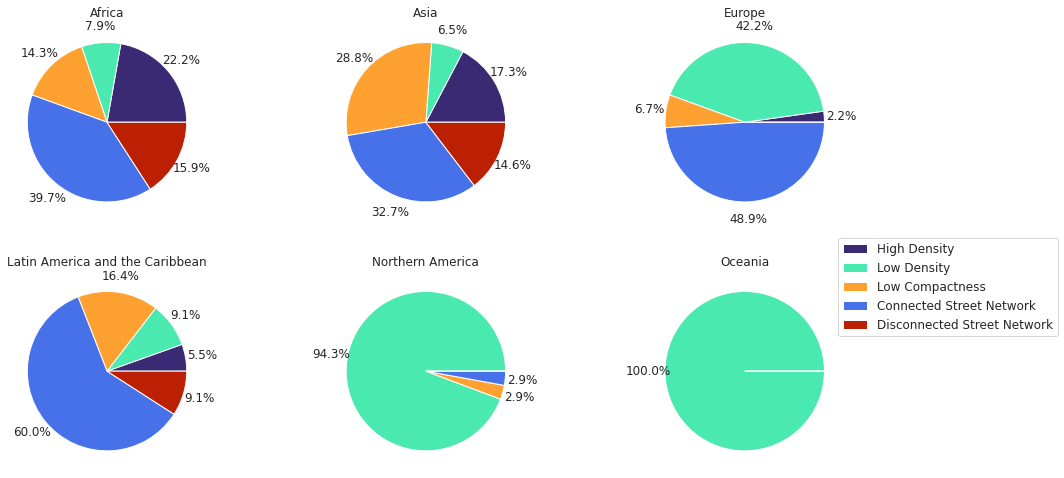

In [60]:
colors = [(0.22500,0.16354,0.45096), (0.29042,0.9137,0.6862), (0.99654,0.63193,0.18738),
          (0.27691,0.44145,0.91328), (0.73661,0.12477,0.00769)]  

plt.figure(dpi=300)
fig, axs = plt.subplots(2, 3, figsize=(15,15), subplot_kw={'aspect':'equal'})
#for ax in axs.flat: 
    #ax.axis('off')
#labels_region = ['Africa','Asia','Europe','Latin America and the Caribbean','Northern America', 'Oceania']
for ax,(groupname,subdf),sublb in zip(axs.flat, df_per_region.groupby('GRGN_L1'), df_per_region.GRGN_L1.unique()):
    ax.pie(subdf.count_city, colors=colors, autopct=lambda p: '{:.1f}%'.format((p)) if p > 0 else '', pctdistance=1.21, textprops={'fontsize':12})
    ax.set_title(sublb,fontsize=12)
fig.subplots_adjust(wspace=0.6, hspace=0.05, top=0.5, bottom=0.05)
labels_cluster = ['High Density','Low Density','Low Compactness','Connected Street Network','Disconnected Street Network']
axs[0,0].legend(bbox_to_anchor=(5.3, -0.05), labels = labels_cluster, fontsize=12)
#title = fig.suptitle('Geographical Distribution of Cities in Clusters', y=.95, fontsize=20)
#fig.savefig('partition_pie_region.png') # Or whichever format you'd like
fig.savefig('Fig4.tif', bbox_extra_artists=(axs[0,0].legend(bbox_to_anchor=(5.3, -0.05), labels = labels_cluster, fontsize=12)
,), bbox_inches='tight', dpi=300)

#### Random Forest Regression 

#### Transportation Emissions - Random Forest Regression SHAP value

In [61]:
joinedGdf_dummy = pd.get_dummies(data=joinedGdf2, columns=['INCM_CMI', 'GRGN_L1', 'cluster_id'])

In [62]:
rfrData = joinedGdf_dummy[['INCM_CMI_HIC', 'INCM_CMI_LIC','INCM_CMI_LMIC','INCM_CMI_UMIC','GRGN_L1_Africa', 'GRGN_L1_Asia', 'GRGN_L1_Europe', 'GRGN_L1_Latin America and the Caribbean', 
                                   'GRGN_L1_Northern America', 'GRGN_L1_Oceania', 'logpop15','log_emissionsPerCap','log_wt_density','compactness','Street_Connectivity', 'density_gradient_intercept', 'density_gradient_slope',
                                   'greenpercap', 'SDG_A2G14', 'pm25Conc']].reset_index() 

In [64]:
# Labels are the values we want to predict
labels = np.array(rfrData['log_emissionsPerCap'])
# Remove the labels from the features
# axis 1 refers to the columns
features= rfrData.drop(['greenpercap','log_emissionsPerCap','SDG_A2G14','pm25Conc', 'id_hdc_g0'], axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)

In [65]:
# Drop null values
rfrData = rfrData.dropna()

In [66]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [67]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [68]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.79 degrees.


In [69]:
from sklearn import metrics

y_true = test_labels # Your real values / test labels
y_pred = predictions # The predictions from your ML / RF model

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
#print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_true, y_pred))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
#print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))
#print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_true, y_pred))
#print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(y_true, y_pred))

Mean Absolute Error (MAE): 0.7926394836474211
Mean Squared Error (MSE): 1.2375664041734207
Root Mean Squared Error (RMSE): 1.112459619120362
Explained Variance Score: 0.2935924235401186
Max Error: 6.608688331895779
Median Absolute Error: 0.612992258330042
R^2: 0.29198097546543855


In [70]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(test_features)

In [71]:
test_features = test_features.rename(columns={'log_wt_density': 'Weighted Density (log)', 'compactness': 'Compactness',
                                             'Street_Connectivity': 'Street Connectivity', 
                                              'density_gradient_intercept': 'Density Gradient Intercept',
                                             'density_gradient_slope': 'Density Gradient Slope'})

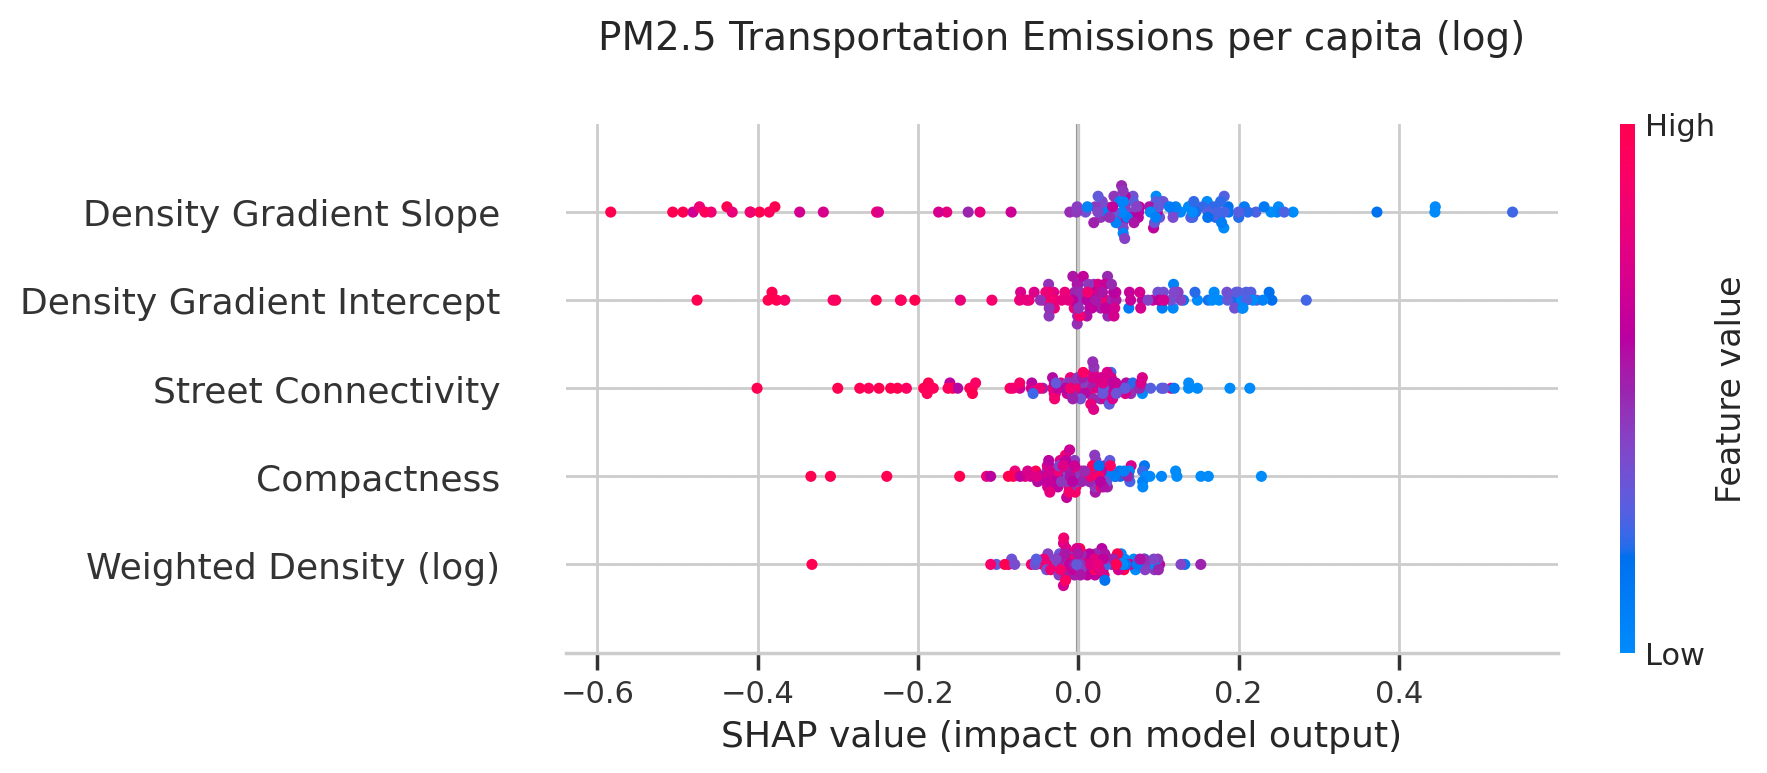

In [72]:
from matplotlib.pyplot import figure
plt.figure(dpi=200)
shap.summary_plot(shap_values[:,11:16], test_features.iloc[:, 11:16], show=False)
plt.title("PM2.5 Transportation Emissions per capita (log)", y=1.11, fontsize=14)
plt.show()

#### Emissions Exposure - Random Forest Regression SHAP value

In [73]:
joinedGdf_dummy = pd.get_dummies(data=joinedGdf2, columns=['INCM_CMI', 'GRGN_L1', 'cluster_id'])

In [74]:
rfrData = joinedGdf_dummy[['INCM_CMI_HIC', 'INCM_CMI_LIC','INCM_CMI_LMIC','INCM_CMI_UMIC','GRGN_L1_Africa', 'GRGN_L1_Asia', 'GRGN_L1_Europe', 'GRGN_L1_Latin America and the Caribbean', 
                                   'GRGN_L1_Northern America', 'GRGN_L1_Oceania', 'logpop15','log_emissionsPerCap','log_wt_density','compactness','Street_Connectivity', 'density_gradient_intercept', 'density_gradient_slope',
                                   'greenpercap', 'SDG_A2G14', 'pm25Conc']].reset_index() 

In [75]:
# Labels are the values we want to predict
labels = np.array(rfrData['pm25Conc'])
# Remove the labels from the features
# axis 1 refers to the columns
features= rfrData.drop(['greenpercap','log_emissionsPerCap','SDG_A2G14','pm25Conc', 'id_hdc_g0'], axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
#features = np.array(features)

In [76]:
# Drop null values
rfrData = rfrData.dropna()

In [77]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [78]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [79]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.41 degrees.


In [80]:
from sklearn import metrics

y_true = test_labels # Your real values / test labels
y_pred = predictions # The predictions from your ML / RF model

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
#print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_true, y_pred))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
#print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))
#print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_true, y_pred))
#print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(y_true, y_pred))

Mean Absolute Error (MAE): 0.40877967876722543
Mean Squared Error (MSE): 0.26120940790716235
Root Mean Squared Error (RMSE): 0.5110864974807712
Explained Variance Score: 0.5557413131907056
Max Error: 1.4384281439911497
Median Absolute Error: 0.3262865861765598
R^2: 0.5346348478124983


In [82]:
test_features = test_features.rename(columns={'log_wt_density': 'Weighted Density (log)', 'compactness': 'Compactness',
                                             'Street_Connectivity': 'Street Connectivity', 
                                              'density_gradient_intercept': 'Density Gradient Intercept',
                                             'density_gradient_slope': 'Density Gradient Slope'})

In [84]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(test_features)

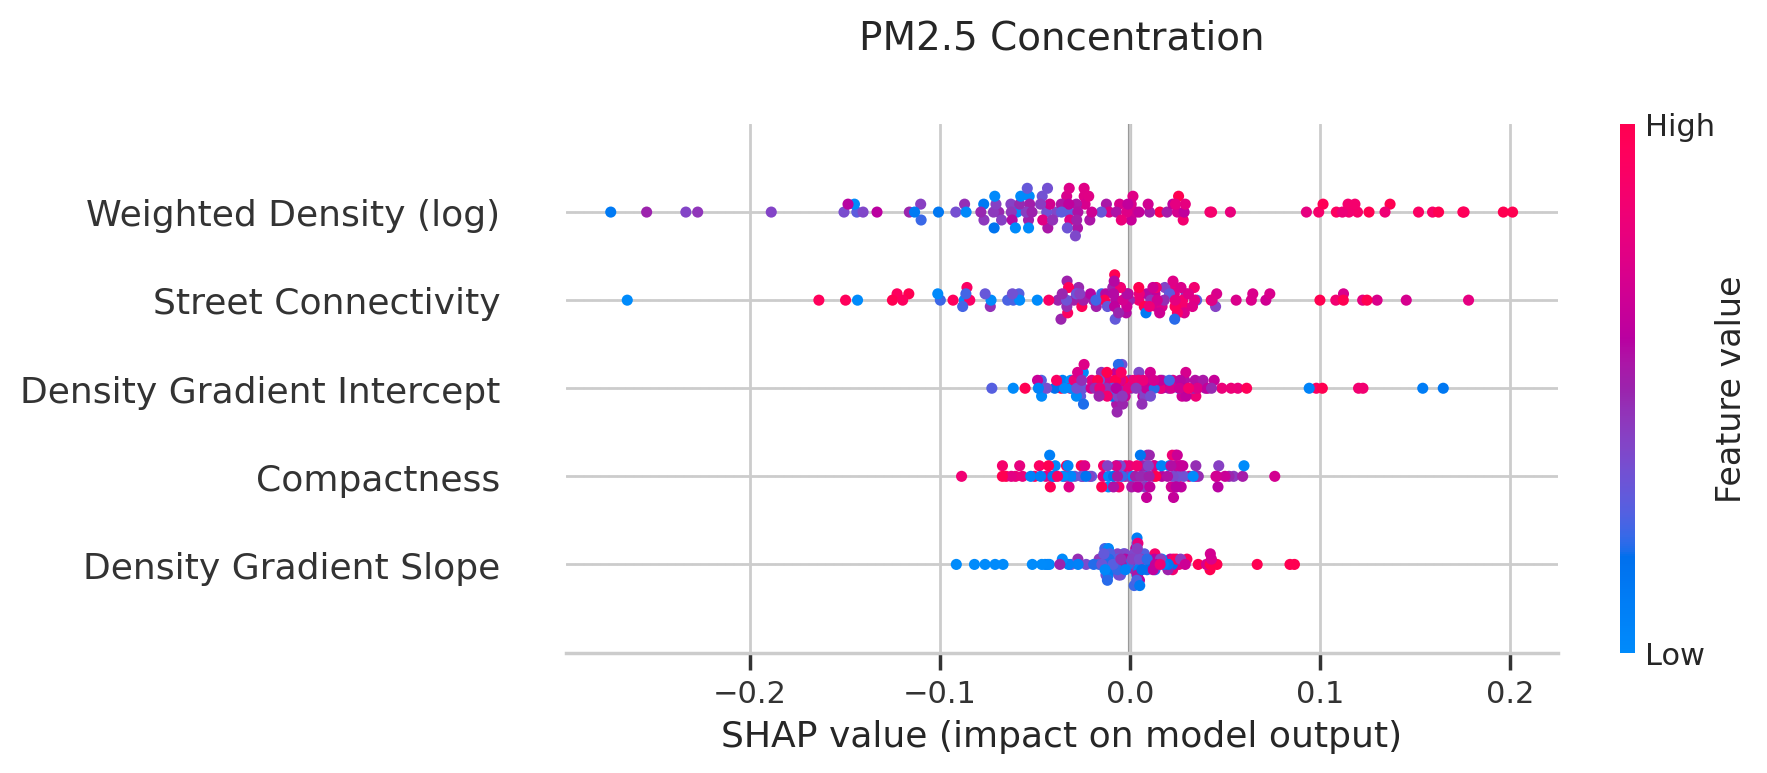

In [85]:
plt.figure(dpi=200)
shap.summary_plot(shap_values[:,11:16], test_features.iloc[:, 11:16], show=False)
plt.title("PM2.5 Concentration", y=1.11, fontsize=14)
plt.show()

#### Green Space per capita - Random Forest Regression SHAP value

In [86]:
joinedGdf_dummy = pd.get_dummies(data=joinedGdf2, columns=['INCM_CMI', 'GRGN_L1', 'cluster_id'])

In [87]:
rfrData = joinedGdf_dummy[['INCM_CMI_HIC', 'INCM_CMI_LIC','INCM_CMI_LMIC','INCM_CMI_UMIC','GRGN_L1_Africa', 'GRGN_L1_Asia', 'GRGN_L1_Europe', 'GRGN_L1_Latin America and the Caribbean', 
                                   'GRGN_L1_Northern America', 'GRGN_L1_Oceania', 'logpop15','log_emissionsPerCap','log_wt_density','compactness','Street_Connectivity', 'density_gradient_intercept', 'density_gradient_slope',
                                   'greenpercap', 'SDG_A2G14', 'pm25Conc']].reset_index()

In [88]:
rfrData['greenpercap'] = rfrData['greenpercap']*1000

In [89]:
# Labels are the values we want to predict
labels = np.array(rfrData['greenpercap'])
# Remove the labels from the features
# axis 1 refers to the columns
features= rfrData.drop(['greenpercap','log_emissionsPerCap','SDG_A2G14','pm25Conc', 'id_hdc_g0'], axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
#features = np.array(features)

In [90]:
# Drop null values
rfrData = rfrData.dropna()

In [91]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [92]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [94]:
from sklearn import metrics

y_true = test_labels # Your real values / test labels
y_pred = predictions # The predictions from your ML / RF model

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
#print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_true, y_pred))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
#print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))
#print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_true, y_pred))
#print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(y_true, y_pred))

Mean Absolute Error (MAE): 0.021376333924169724
Mean Squared Error (MSE): 0.0009035314809222472
Root Mean Squared Error (RMSE): 0.030058800390605198
Explained Variance Score: 0.9662060083531236
Max Error: 0.1212177140423154
Median Absolute Error: 0.014993215389132217
R^2: 0.965506480194741


In [96]:
test_features = test_features.rename(columns={'log_wt_density': 'Weighted Density (log)', 'compactness': 'Compactness',
                                             'Street_Connectivity': 'Street Connectivity', 
                                              'density_gradient_intercept': 'Density Gradient Intercept',
                                             'density_gradient_slope': 'Density Gradient Slope'})

In [97]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(test_features)

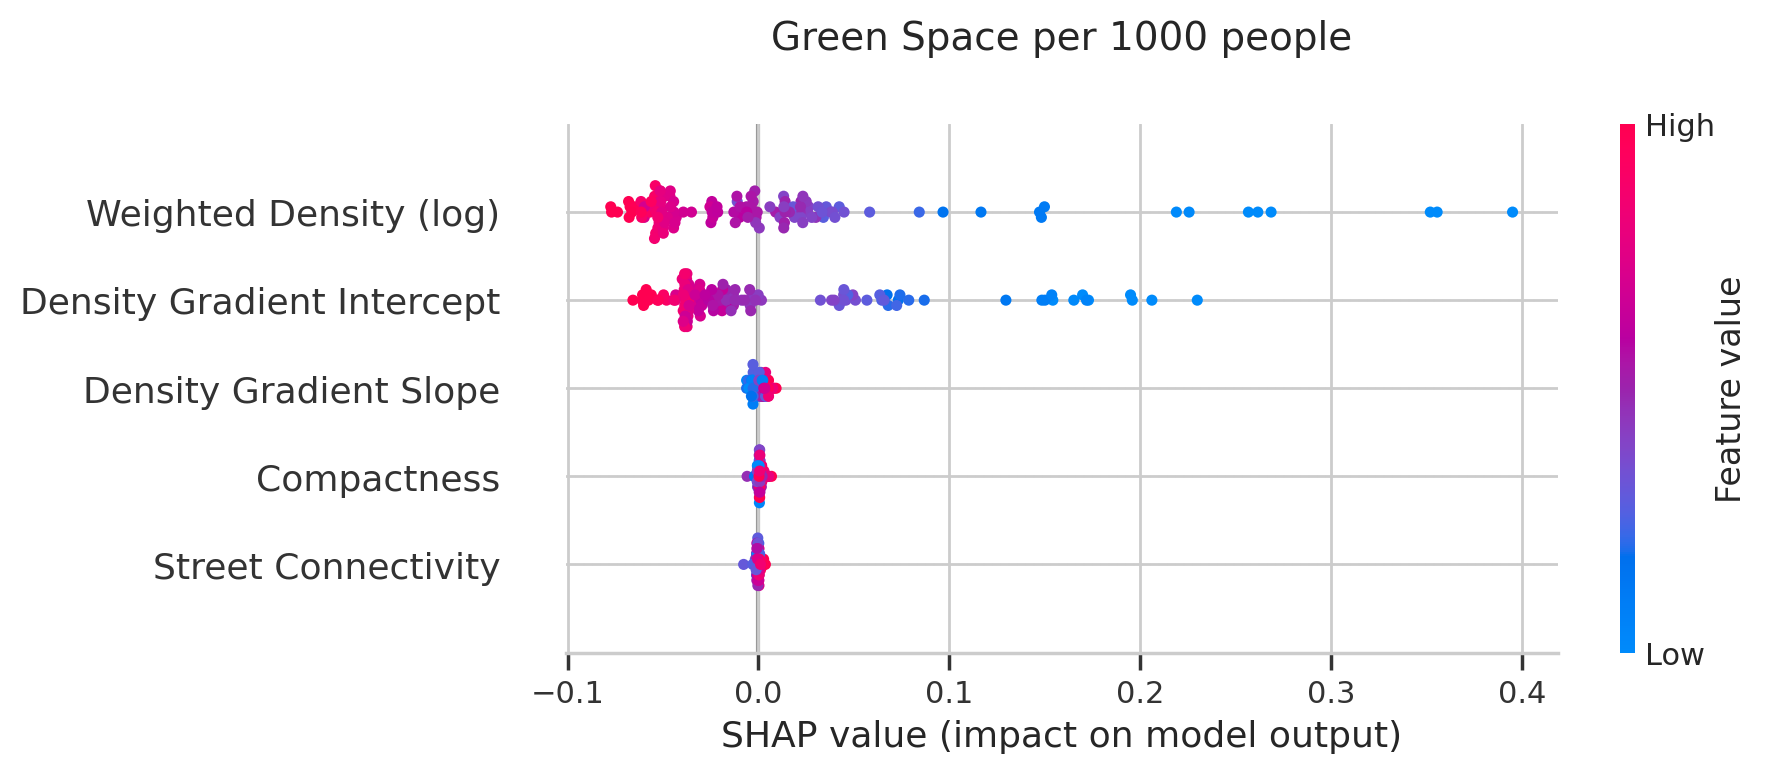

In [98]:
plt.figure(dpi=200)
shap.summary_plot(shap_values[:,11:16], test_features.iloc[:, 11:16], show=False)
plt.title("Green Space per 1000 people", y=1.11, fontsize=14)
plt.show()

#### Access to Green Space - Random Forest Regression SHAP value

In [99]:
joinedGdf_dummy = pd.get_dummies(data=joinedGdf2, columns=['INCM_CMI', 'GRGN_L1', 'cluster_id'])

In [100]:
rfrData = joinedGdf_dummy[['INCM_CMI_HIC', 'INCM_CMI_LIC','INCM_CMI_LMIC','INCM_CMI_UMIC','GRGN_L1_Africa', 'GRGN_L1_Asia', 'GRGN_L1_Europe', 'GRGN_L1_Latin America and the Caribbean', 
                                   'GRGN_L1_Northern America', 'GRGN_L1_Oceania', 'logpop15','log_emissionsPerCap','log_wt_density','compactness','Street_Connectivity', 'density_gradient_intercept', 'density_gradient_slope',
                                   'greenpercap', 'SDG_A2G14', 'pm25Conc']].reset_index()  

In [101]:
# Labels are the values we want to predict
labels = np.array(rfrData['SDG_A2G14'])
# Remove the labels from the features
# axis 1 refers to the columns
features= rfrData.drop(['greenpercap','log_emissionsPerCap','SDG_A2G14','pm25Conc', 'id_hdc_g0'], axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
#features = np.array(features)

In [102]:
# Drop null values
rfrData = rfrData.dropna()

In [103]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [104]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [105]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.1 degrees.


In [106]:
from sklearn import metrics

y_true = test_labels # Your real values / test labels
y_pred = predictions # The predictions from your ML / RF model

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
#print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_true, y_pred))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
#print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))
#print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_true, y_pred))
#print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(y_true, y_pred))

Mean Absolute Error (MAE): 0.10153619088326622
Mean Squared Error (MSE): 0.02110259149994605
Root Mean Squared Error (RMSE): 0.14526731050014677
Explained Variance Score: 0.6275341118481522
Max Error: 0.5437965005860683
Median Absolute Error: 0.05502195117937477
R^2: 0.6274598635478679


In [108]:
test_features = test_features.rename(columns={'log_wt_density': 'Weighted Density (log)', 'compactness': 'Compactness',
                                             'Street_Connectivity': 'Street Connectivity', 
                                              'density_gradient_intercept': 'Density Gradient Intercept',
                                             'density_gradient_slope': 'Density Gradient Slope'})

In [109]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(test_features)

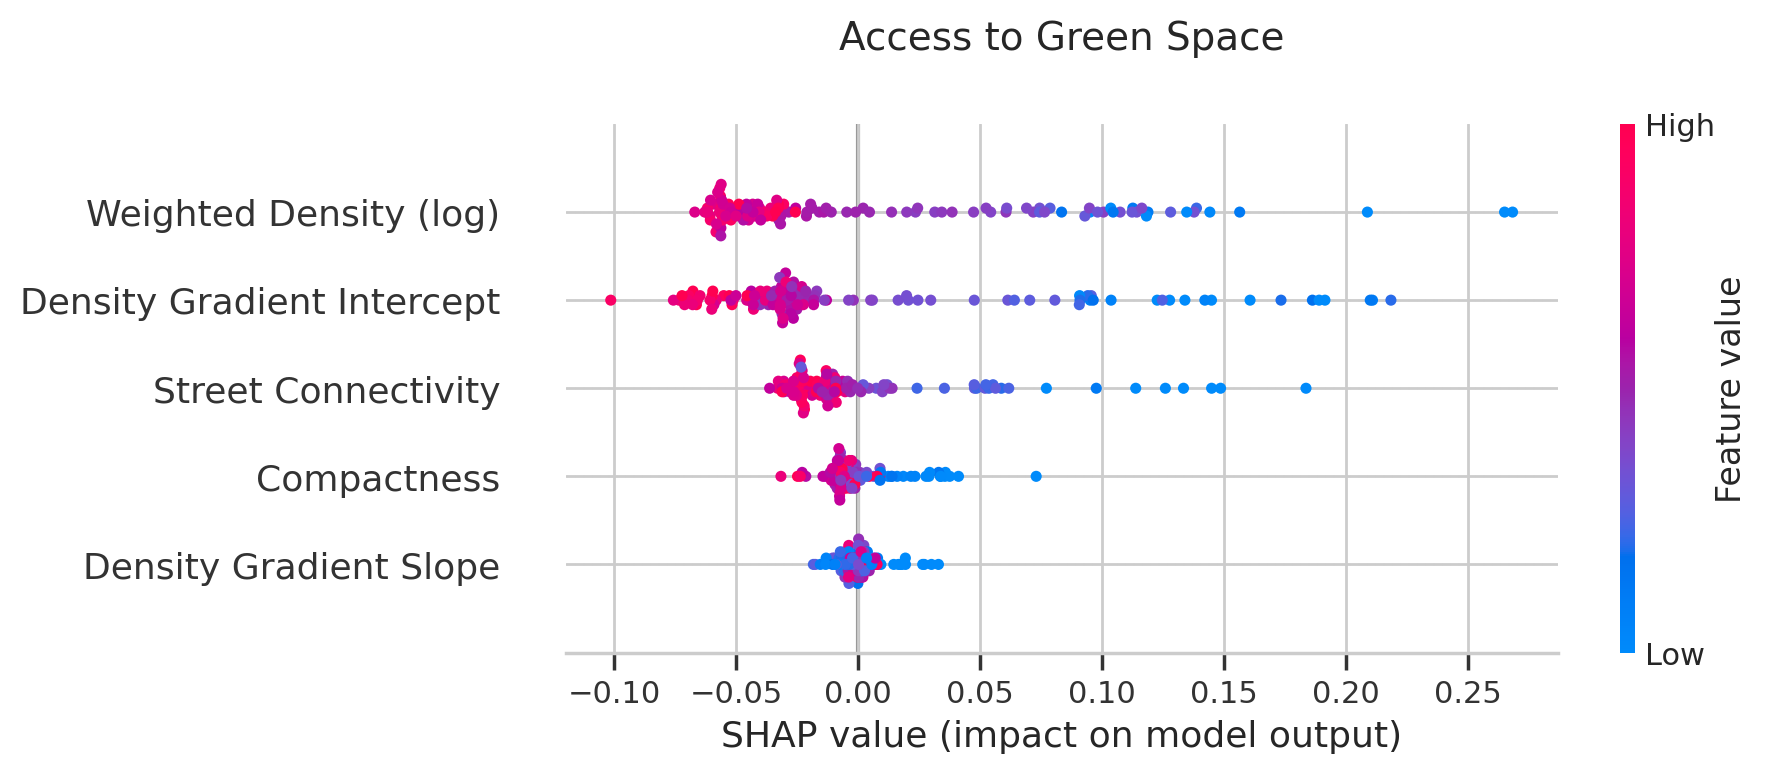

In [110]:
plt.figure(dpi=200)
shap.summary_plot(shap_values[:,11:16], test_features.iloc[:, 11:16], show=False)
plt.title("Access to Green Space", y=1.11, fontsize=14)
plt.show()